In [1]:
import numpy as np

import awkward as ak
import uproot as uproot

import scipy.special as sp
import sklearn as sk

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pprint

## Setup

In [2]:
# Path to the folder to saves plots
# Don't forget the last '/'
viz_folder_path = "/sps/t2k/eleblevec/updated_watchmal/WatChMaL/outputs/2025-02-13/03-52-26/"

# Path to the folder containing .npy files
# Don't forget the last '/'
npy_folder_path = "/sps/t2k/eleblevec/updated_watchmal/WatChMaL/outputs/2025-02-13/03-52-26/"

## Load the files

#### -- Model's output

In [3]:
indices, preds, targets = np.load(npy_folder_path + 'indices.npy'), np.load(npy_folder_path + 'preds.npy'), np.load(npy_folder_path + 'targets.npy')

print(f"Indices : {indices[:10]} \nPreds : {preds[:10]} \nTargets : {targets[:10]}")

Indices : [ 7  3  6 18  4  5 11 16 14  8] 
Preds : [[-0.10375246 -0.06708494]
 [-0.13265207 -0.03632846]
 [-0.06331726 -0.05960358]
 [-0.05036309 -0.03916815]
 [-0.0717916  -0.03420111]
 [-0.10759834 -0.02027409]
 [-0.04769336 -0.07706454]
 [-0.04789575 -0.02869712]
 [-0.08193741 -0.05193449]
 [-0.06966659 -0.0549828 ]] 
Targets : [1 1 1 0 1 1 0 0 0 1]


### Predictions counter

In [4]:
target_names = ['mu-', 'e-'] # Order matters

print(f"'{target_names[0]}': {np.sum(np.argmax(preds,axis=1) == 0)}, '{target_names[1]}': {np.sum(np.argmax(preds,axis=1) == 1)}")

'mu-': 1, 'e-': 11


### Confusion matrix

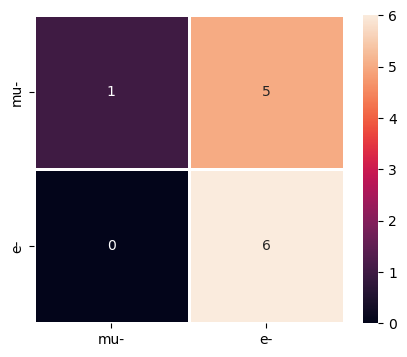

In [7]:
softmax_preds = sp.softmax(preds, axis=1)
predicted_classes = np.argmax(softmax_preds, axis=1)
cm = sk.metrics.confusion_matrix(targets, predicted_classes)

df_cm = pd.DataFrame(
    cm,
    index=[i for i in target_names],
    columns=[c for c in target_names]
)

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(df_cm, ax=ax, annot=True, linewidths=0.8)
plt.show()

### ROC Curves

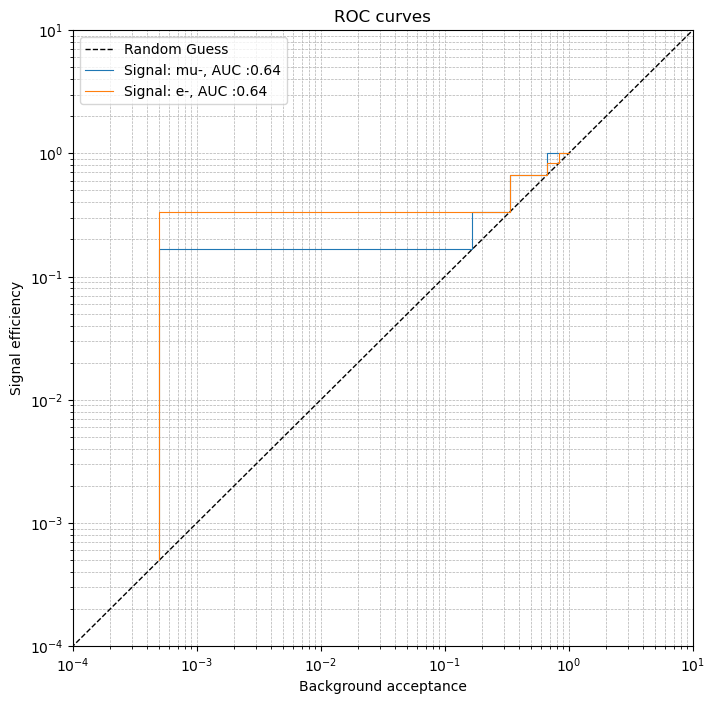

In [8]:
target_names = ['mu-', 'e-'] # order matter

# Global figure parameters
figsize=(8, 8)
log_scale = True

fig, ax = plt.subplots(figsize=figsize)

# Display performances of a random classifier
ax.plot([1e-6, 10], [1e-6, 10], 'k--', label='Random Guess', lw=1)


# --- Computing the ROC curves --- #
for i, target_name in enumerate(target_names):
    signal_index = i # Should be 0 for muon, 1 for electron

    softmax_preds = sp.softmax(preds, axis=1)
    signal_class_preds = softmax_preds[:, signal_index]

    # Compute fpr, tpr and corresponding auc
    fpr, tpr, _ = sk.metrics.roc_curve(targets == signal_index, signal_class_preds)
    roc_auc = sk.metrics.auc(fpr, tpr)

    # Plots
    if log_scale:
        # Handling of 0 values if any
        fpr = np.where(fpr <= 5e-4, 5e-4, fpr)
        tpr = np.where(tpr <= 5e-4, 5e-4, tpr)

    ax.plot(fpr, tpr, label=f"Signal: {target_name}, AUC :{roc_auc:.2f}", lw=0.8)
    ax.legend()



# Increase appearence 
plt.title(f"ROC curves")
ax.set_xlim([1e-4, 10]) 
ax.set_ylim([1e-4, 10])

if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')

plt.grid(True, which='both',  ls='--', lw=0.5)

plt.xlabel('Background acceptance')
plt.ylabel('Signal efficiency')

plt.legend()
plt.show()

In [9]:
save_fig = True
suffix="_test"
if save_fig:
    fig.savefig(viz_folder_path + "roc_curve" + suffix + ".png", dpi=300)